In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import commands
import PIL
import os

class Glam2(object):
    """Python wrapper for 'glam2 (vers)' motif discovery tool.
    Original usage: Usage: glam2 [options] alphabet my_seqs.fa

    Attributes:
        alphabet: "p" for proteins, "n" for nucleotides (n)
        fasta_file: Input file with sequences in FASTA format
        outptu_dir: Directory to save the output (glam2_out); -O TODO: check path compatibility
        number_alignment_runs: number of alignment runs (10); -r
        number_iterations: end each run after this many iterations without improvement (10000); -n
        both_strands: examine both strands - forward and reverse complement; -2
        min_sequences: minimum number of sequences in the alignment (2); -z
        min_aligned_columns: minimum number of aligned columns (2); -a
        max_aligned_columns: maximum number of aligned columns (50); -b
        initial_aligned_columns: initial number of aligned columns (20); -w
        threshold: 
    """
    
    def __init__(self, alphabet = "n",
                 fasta_file = "", #seperate this
                 output_dir = "glam2_out",
                 number_alignment_runs = 10,
                 number_iterations = 10000,
                 both_strands = 0,
                 min_sequences = 2,
                 min_aligned_columns = 2,
                 max_aligned_columns = 50,
                 initial_aligned_columns = 20,
                 threshold = 0
                 ):
        """Returns a Glam2 object with specified attribute values."""
        self.alphabet = alphabet
        self.fasta_file = fasta_file
        self.output_dir = output_dir #-O
        self.number_alignment_runs = number_alignment_runs    #-r
        self.number_iterations = number_iterations     #-n
        self.both_strands = both_strands    #-2
        self.min_sequences = min_sequences    #-z
        self.min_aligned_columns = min_aligned_columns    #-a
        self.max_aligned_columns = max_aligned_columns    #-b
        self.initial_aligned_columns = initial_aligned_columns    #-w
        self.threshold = threshold
        
        #self.scores = []
        #self.score_line_num = []
        #self.scores_threshold = []


    def fit(self, fasta_file):
        """Executes the command on terminal and returns the output."""
        
        if fasta_file == "": return "Input file not specified"
        

        
        command = "glam2"\
                    + " -O " + self.output_dir\
                    + " -r " + str(self.number_alignment_runs)\
                    + " -n " + str(self.number_iterations)
        
        if self.both_strands == 1: command = command + " -2 "
        
        command = command + " -z " + str(self.min_sequences)\
                    + " -a " + str(self.min_aligned_columns)\
                    + " -b " + str(self.max_aligned_columns)\
                    + " -w " + str(self.initial_aligned_columns)\
                    + " " + self.alphabet + " " + fasta_file
        
        status, output = commands.getstatusoutput(command)
        if status !=0:
            print "Error: Command not executed on terminal."
            return output
                        
        return output

            
    def predict(self, return_list = False):
        """Outputs 1 integer per sequence indicating the motif id present in the sequence"""
        #TODO: glam2 returns 1 motif per sequence, because actually these are alignments
        #TODO: motifs in other portions are maybe repetitions
        #TODO: check if dots between key positions are important
        
        #filename = os.path.join('glam2_out', 'glam2.txt') ##<-- self.output_dir
        filename = os.path.join(self.output_dir, 'glam2.txt')
        with open(filename, 'r') as f:
            lines = f.readlines()
            
            n_seqs = int(lines[4][11:])    #Number of sequences in the text file
            #max_sequence_length = int(lines[5][27:])
            
            #Creating a list of alignment scores#
            n=7 #first line in txt file to start the search for
            scores = []
            score_line_num = []
            while(len(scores) < 10):    #self.number_alignment_runs):    #loop for reading all scores
                if lines[n].find("Score:")!=-1:
                    score_line_num.append(n)
                    scores.append( float(lines[n].split(" ")[1] ) )
                n+=1
            
            #print scores
            
            all_motifs = []
            #motif_id = []
            motif_list=[] #TODO:[[]] * n_seqs#to store the motif_id for each sequence
            motif_count = [0] * n_seqs    #if return_list = False
            
            k=0    
            while(scores[k]>= self.threshold): #self.threshold):    #Loop over portions
                
                key_positions = [] #to store indices of key positions
                for i,j in enumerate(lines[score_line_num[k]+2]):    #Loop over key-positions line
                    if j=='*':
                        key_positions.append(i)

                aligns_line = score_line_num[k] + 3
                for i in range(aligns_line, aligns_line + n_seqs): #Loop over alignment lines
                    motif = []
                    for j in range(len(key_positions)):
                        motif.append(lines[i][key_positions[j]])

                    if motif not in all_motifs:
                        motif_count[i-aligns_line]+=1
                        all_motifs.append(motif)
                        
                    motif_list.append(all_motifs.index(motif))
                    
                k+=1        
        
        #using strategy that each sequence gives one motif, reshape the motif list
        #TODO: make a better motif_list
        motif_list_reshape=[]
        for i in range(n_seqs):
            x=[]
            for j in range(len(motif_list)/n_seqs):
                x.append(motif_list[i+(j*n_seqs)])
            motif_list_reshape.append(x)
        

        if return_list == False:
            return motif_count
        return motif_list_reshape
    
    def fit_predict(self, fasta_file, return_list = False):
        self.fit(fasta_file)
        return self.predict(return_list=return_list)

    def transform(self, return_match = False):
        pass
        
    def logos(self, image_num= -1):
        """Displays the ten Sequence logos generated."""
        
        script_dir = os.path.dirname(self.output_dir)
        images = []
        for i in range(1,(self.number_alignment_runs + 1)):
            image_path = "logo" + str(i) + ".png"
            abs_file_path = os.path.join(self.output_dir, image_path)
        
            images.append(PIL.Image.open(abs_file_path))
        
        if image_num == -1:
            for image in images:
                plt.figure()
                plt.imshow(image)
        else:
            plt.figure()
            plt.imshow(images[image_num])

    def display_glam2_help(self):
        command = "glam2 -h"
        print commands.getoutput(command)

In [6]:
#Glam2().display_glam2_help()

In [7]:
#method fit: takes fasta file, logging for output, rename this to fit (with input as fasta file)
#same fit, predict as that of eden motif::DONE
#threshold score in init for motifs, below the threshold are not reported::DONE
#transform: gives score per sequence, return list true gives same output as eden motif

#biopython, columns frequencies for entropy

In [8]:
#Example
obj = Glam2(alphabet = "p",
           number_alignment_runs = 10,
           threshold = 1000)
output = obj.fit("At.faa")#fasta_file = "seq.fa") 
print output

The output directory 'glam2_out' already exists.
Its contents will be overwritten.
Run 1... 37195 iterations
Run 2... 20815 iterations
Run 3... 21832 iterations
Run 4... 22063 iterations
Run 5... 32242 iterations
Run 6... 10928 iterations
Run 7... 18990 iterations
Run 8... 17324 iterations
Run 9... 16572 iterations
Run 10... 20700 iterations



In [9]:
predictions = obj.predict(return_list = True)
for p in predictions: print p

[0, 15, 30]
[0, 15, 30]
[0, 15, 30]
[1, 16, 31]
[2, 17, 32]
[2, 17, 32]
[3, 18, 33]
[4, 19, 34]
[5, 20, 35]
[6, 21, 36]
[7, 22, 37]
[8, 23, 38]
[9, 24, 39]
[10, 25, 40]
[11, 26, 41]
[12, 27, 42]
[13, 28, 43]
[14, 29, 44]
[14, 29, 44]


In [10]:
predictions = obj.predict(return_list = False)
for p in predictions: print p
#TODO: glam2 gives one motif per sequence

3
0
0
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
0


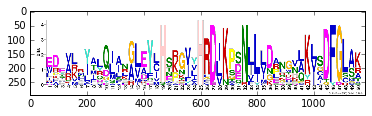

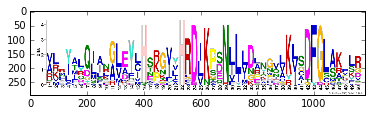

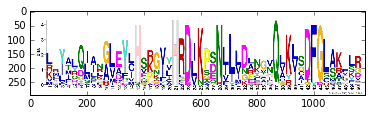

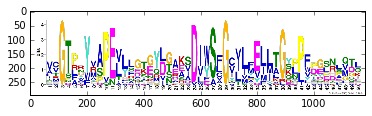

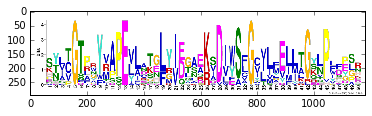

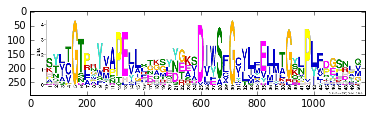

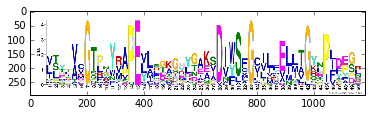

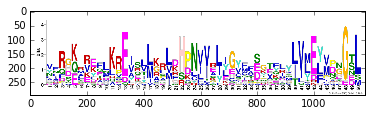

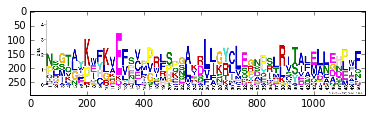

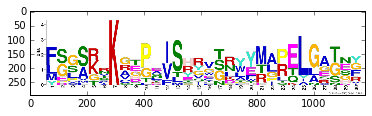

In [11]:
#display sequence logos
obj.logos(image_num=-1)

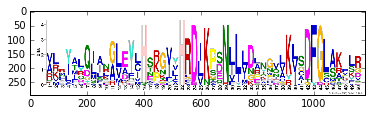

In [12]:
obj.logos(image_num=1)

In [215]:
obj2 = Glam2(alphabet = "p",
             number_alignment_runs = 10,
             output_dir = "output_dir",
             threshold = 1000)

predictions = obj2.fit_predict(fasta_file = "At.faa", return_list = True)
for p in predictions: print p

[0, 15, 30]
[0, 15, 30]
[0, 15, 30]
[1, 16, 31]
[2, 17, 32]
[2, 17, 32]
[3, 18, 33]
[4, 19, 34]
[5, 20, 35]
[6, 21, 36]
[7, 22, 37]
[8, 23, 38]
[9, 24, 39]
[10, 25, 40]
[11, 26, 41]
[12, 27, 42]
[13, 28, 43]
[14, 29, 44]
[14, 29, 44]


In [ ]:
def transform(return_match = False):
    pass

In [13]:
obj3 = Glam2(alphabet = "n",
             number_alignment_runs = 10,
             output_dir = "test",
             threshold = 10)
print obj3.fit("seq.fa")

The output directory 'test' already exists.
Its contents will be overwritten.
Run 1... 24740 iterations
Run 2... 21327 iterations



In [4]:
predictions3 = obj.predict(return_list = True)
for p in predictions3: print p

[0, 15, 30]
[0, 15, 30]
[0, 15, 30]
[1, 16, 31]
[2, 17, 32]
[2, 17, 32]
[3, 18, 33]
[4, 19, 34]
[5, 20, 35]
[6, 21, 36]
[7, 22, 37]
[8, 23, 38]
[9, 24, 39]
[10, 25, 40]
[11, 26, 41]
[12, 27, 42]
[13, 28, 43]
[14, 29, 44]
[14, 29, 44]
